In [1]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.constants import c
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt

# Configuration

In [115]:
nside = 64 # (good to use a power of 2)
smoothing_scale = 0.7 # smoothing scale in degrees
zmin = 0.0 # minimum redshift
zmax = 0.2 # maximum redshift
fname = '2MRS_map_all'

print('resolution: {:0.2f} deg'.format(np.degrees(hp.nside2resol(nside))))
print('number of pixels: {:d}'.format(hp.nside2npix(nside)))

resolution: 0.92 deg
number of pixels: 49152


In [116]:
def cat2hpx(lon, lat, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates

    """

    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, frame='icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

# Load 2MASS Redshift Survey data

In [117]:
hdu = fits.open('2MASS_catalogs/catalog/2mrs_1175_done.fits')
cat = hdu[1].data

# Create map

In [118]:
pixarea = hp.nside2pixarea(nside,degrees=True)
zvals = cat['V']/c.to('km/s').value
zcond = np.logical_and(zvals>=zmin, zvals<zmax)
catmap = cat2hpx(cat['GLON'][zcond],cat['GLAT'][zcond],nside)/pixarea
catmap_smoothed = hp.smoothing(catmap, fwhm=np.radians(smoothing_scale))

# Generate visualization

0.0 180.0 -180.0 180.0


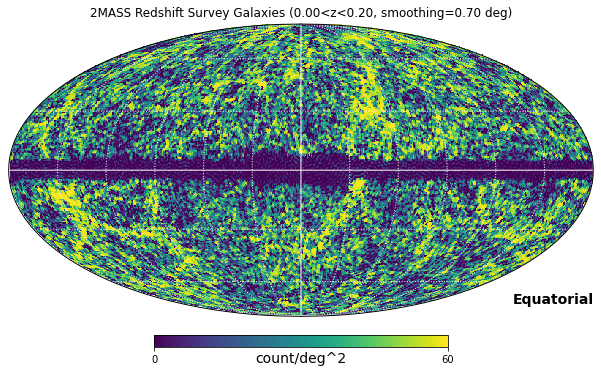

In [124]:
hp.mollview(
    catmap_smoothed,
    coord=["G","C"],
    unit='count/deg^2',
    title="2MASS Redshift Survey Galaxies ({:0.2f}<z<{:0.2f}, smoothing={:0.2f} deg)".format(zmin,zmax,smoothing_scale),
    norm="hist",
    min=0,
    max=60
)
hp.graticule(color='white')
plt.savefig(fname+'_smoothed.pdf',format='pdf')

0.0 180.0 -180.0 180.0


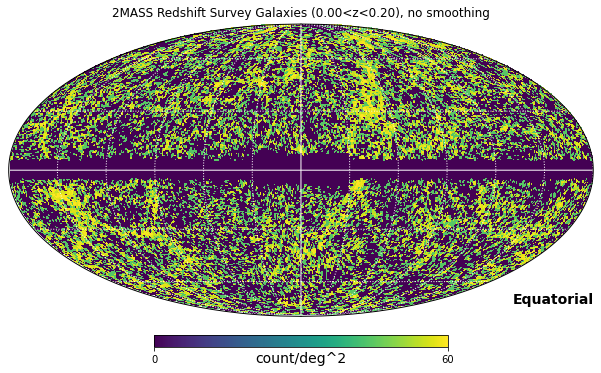

In [125]:
hp.mollview(
    catmap,
    coord=["G","C"],
    unit='count/deg^2',
    title="2MASS Redshift Survey Galaxies ({:0.2f}<z<{:0.2f}), no smoothing)".format(zmin,zmax),
    norm="hist",
    min=0,
    max=60
)
hp.graticule(color='white')
plt.savefig(fname+'.pdf',format='pdf')

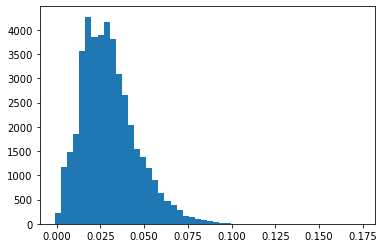

In [94]:
_=plt.hist(cat['V']/c.to('km/s').value,50)